# Libraries

In [2]:
import numpy as np
import pandas as pd

# Importing necessary libraries for this notebook.
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from datetime import datetime
import time
from decimal import Decimal

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, f1_score

from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Dropout, BatchNormalization, LeakyReLU, LSTM
from keras.regularizers import l2, l1
from keras.metrics import BinaryAccuracy
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint

import os
from google.colab import files

# Compress the directory into a zip file
import shutil
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*You are saving your model as an HDF5 file.*")

# Functions

In [3]:
def split_data(X, y):
  X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

  # Print the sizes of each set
  print(f"Training set size: {X_train.shape[0]}")
  print(f"Validation set size: {X_val.shape[0]}")
  print(f"Test set size: {X_test.shape[0]}")

  return X_train, X_val, X_test, y_train, y_val, y_test

In [4]:
def scale_data(scaler, X_train, X_val, X_test):
  columns = X_train.columns
  scaler.fit(np.array(X_train[columns]))

  X_train[columns] = scaler.transform(np.array(X_train[columns]))
  X_val[columns] = scaler.transform(np.array(X_val[columns]))
  X_test[columns] = scaler.transform(np.array(X_test[columns]))

  return X_train, X_val, X_test

In [5]:
def create_model(input_dim, kernel_regularizer = None, dropout = False):
  model = Sequential()
  model.add(Dense(32, activation='relu', input_dim=input_dim, kernel_regularizer=kernel_regularizer))
  if dropout:
    model.add(Dropout(0.2))
  model.add(Dense(16, activation='relu', kernel_regularizer=kernel_regularizer))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
  return model

In [7]:
def evaluate(model, history, X_train, y_train, X_test, y_test, training_time, mode_name):
  y_pred = model.predict(X_test)
  y_pred = [1 if i >= threshold else 0 for i in y_pred]

  # Evaluate the model
  train_accuracy = round((model.evaluate(X_train, y_train, verbose=0)[1]*100),2)
  val_accuracy = round((history.history['val_accuracy'][-1]*100),2)
  test_accuracy = round((model.evaluate(X_test, y_test, verbose=0)[1]*100),2)

  f1 = round(f1_score(y_test, y_pred)*100,2)
  # Length of data
  data_length = len(X_train)

  # Store results in a dictionary
  results = [f1, train_accuracy, val_accuracy, test_accuracy, data_length, training_time]
  print(f"Results of {mode_name} dataset")
  #print results
  print(f"F1 Score on test data: {f1}")
  print("Accuracy train data: {}%".format(train_accuracy))
  print("Accuracy validation data: {}%".format(val_accuracy))
  print("Accuracy test data: {}%".format(test_accuracy))
  print("Data length: {}".format(data_length))
  print("Training time: {} seconds".format(round(training_time)))

  return results

In [17]:
def split_and_scale_chronologically(X, y, features_cols, target_col, time_steps = 15, overlap = 14):

    # Split data
    print("Splitting data...")
    # Determine split indices
    train_size = int(len(X) * 0.6)
    val_size = int(len(X) * 0.2)
    test_size = len(X) - train_size - val_size

    # Split the data chronologically
    X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
    y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]
    print(f"Training set size: {X_train.shape[0]}")
    print(f"Validation set size: {X_val.shape[0]}")
    print(f"Test set size: {X_test.shape[0]}")

    # Create sequences for X and y
    X_train_sequences = create_lstm_sequences(X_train, time_steps, overlap)
    X_val_sequences = create_lstm_sequences(X_val, time_steps, overlap)
    X_test_sequences = create_lstm_sequences(X_test, time_steps, overlap)

    # Create corresponding target sequences (use the last value in each sequence as the target)
    y_train_sequences = y_train[time_steps-1::time_steps-overlap]
    y_val_sequences = y_val[time_steps-1::time_steps-overlap]
    y_test_sequences = y_test[time_steps-1::time_steps-overlap]

    # Check shapes
    print(f"Shape of X_train: {X_train_sequences.shape}")  # Should be (num_sequences, time_steps, num_features)
    print(f"Shape of y_train: {y_train_sequences.shape}")  # Should be (num_sequences, time_steps, 1)

    # Scale data
    print("\nScaling data...")
    scaler = MinMaxScaler()
    X_train_scaled, X_val_scaled, X_test_scaled = scale_data_lstm(scaler, X_train_sequences, X_val_sequences, X_test_sequences)


    return X_train_scaled, X_val_scaled, X_test_scaled, y_train_sequences, y_val_sequences, y_test_sequences, scaler

In [18]:
def train_and_evaluate_model(df, target_col, features_cols, kernel_regularizer, dropout,
                   batch_size, test_data_provided = False,
                   df_test = None, data_set_name = "data_set", lstm_model = False, create_model = create_model, deploy = False,
                   test_set_name = "test", train_set_name = "train", time_steps = 15, overlap = 14):

    # Split and scale data
    if lstm_model:
      X = df[features_cols].values
      y = df[target_col].values
      X_train, X_val, X_test, y_train, y_val, y_test, scaler = split_and_scale_chronologically(X, y, features_cols, target_col,  time_steps = time_steps, overlap = overlap)

      input_shape = (X_train.shape[1], X_train.shape[2])
      model = create_lstm_model(input_shape)
    else:
      X = df[features_cols]
      y = df[target_col]
      X_train, X_val, X_test, y_train, y_val, y_test, scaler = split_and_scale(X, y, features_cols, target_col, test_data_provided, df_test)

      # Create model
      input_dim = X_train.shape[-1]
      print(f"\nInput dimension: {input_dim}")

      model = create_model(input_dim, kernel_regularizer=kernel_regularizer, dropout=dropout)



    # Create a new directory
    save_dir = '/content/' + data_set_name
    if not os.path.exists(save_dir):
      os.makedirs(save_dir, exist_ok=True)
    best_model_name = 'best_' + data_set_name + '_model.h5'
    model_path = os.path.join(save_dir, best_model_name)

    # Early stopping and checkpoint
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(model_path, save_best_only=True, monitor='val_loss')

    # Train model
    if deploy:
      epochs = 200
    else:
      epochs = 100

    print(f"\nTraining model with batch_size = {batch_size} and {epochs} epochs...")
    print(f"\nSaving best model to {model_path}")
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val),
              callbacks=[early_stopping, model_checkpoint], verbose=0)
    # Load the best model based on the saved weights
    model = load_model(model_path)
    print(f"\nBest model loaded from {model_path}")

    # Evaluate model
    test_accuracy, f1, threshold = run_metrics(model, X_test, y_test, threshold_range=np.arange(0.1, 0.9, 0.1), cv_folds=5)

    # Extract the train and test dataframes scaled
    if deploy:
      extract_data(X_test, y_test, X_train, y_train, test_accuracy, f1, threshold, scaler, features_cols, data_set_name, test_set_name, train_set_name, save_dir)
    else:
      delete_save_dir(save_dir)

    return model, scaler, test_accuracy, f1, threshold

# Constants

In [19]:
# best results from Best_model_selection notebook
best_kernel_regularizer = None
best_dropout = False

In [20]:
best_batch_size = 32
best_epochs = 100

In [21]:
threshold = 0.45

In [23]:
df_HVAC = pd.read_csv("/content/sample_data/HVAC.csv")
target_column = "occupancy"
feature_columns = df_HVAC.columns.drop([target_column, "datetime"]).tolist()
no_time_feature_columns = df_HVAC.columns.drop([target_column, "datetime", "hour_of_the_day", "day_number_of_the_week", "day_of_year"]).tolist()
acceleration_columns = ['temperature','humidity','co2_concentration','average_co2_last_hour','average_temperature_last_hour',
           'average_humidity_last_hour','current_value_minus_average_last_hour_co2','current_value_minus_average_last_hour_temperature',
           'current_value_minus_average_last_hour_humidity','current_value_minus_last_15_min_co2','current_value_minus_last_15_min_temperature',
           'current_value_minus_last_15_min_humidity','acceleration_co2','acceleration_temperature','acceleration_humidity','room_number','floor_area']

**Notations**

no_time = we remove the time features from the data set

variation = we only use the variation features

# HVAC Dataset

https://www.kaggle.com/code/turksoyomer/hvac-occupancy-detection-with-ml-and-dl-methods/input

In [ ]:
df_HVAC = pd.read_csv("/content/sample_data/HVAC.csv")

## Data Exploration

In [ ]:
print(df_HVAC.info())
df_HVAC.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20560 entries, 0 to 20559
Data columns (total 19 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   datetime                                           20560 non-null  object 
 1   temperature                                        20560 non-null  float64
 2   humidity                                           20560 non-null  float64
 3   co2_concentration                                  20560 non-null  float64
 4   average_co2_last_hour                              20560 non-null  float64
 5   average_temperature_last_hour                      20560 non-null  float64
 6   average_humidity_last_hour                         20560 non-null  float64
 7   current_value_minus_average_last_hour_co2          20560 non-null  float64
 8   current_value_minus_average_last_hour_temperature  20560 non-null  float64
 9   curren

,datetime,temperature,humidity,co2_concentration,average_co2_last_hour,average_temperature_last_hour,average_humidity_last_hour,current_value_minus_average_last_hour_co2,current_value_minus_average_last_hour_temperature,current_value_minus_average_last_hour_humidity,current_value_minus_last_15_min_co2,current_value_minus_last_15_min_temperature,current_value_minus_last_15_min_humidity,room_number,hour_of_the_day,day_number_of_the_week,day_of_year,floor_area,occupancy
0,2015-02-02 14:19:00,23.7000,26.272,749.200000,749.200000,23.700000,26.27200,0.000000,0.000000,0.00000,0.000000,0.0000,0.000,17,14,1,33,20,1
1,2015-02-02 14:19:59,23.7180,26.290,760.400000,760.400000,23.718000,26.29000,0.000000,0.000000,0.00000,11.200000,0.0180,0.018,17,14,1,33,20,1
2,2015-02-02 14:21:00,23.7300,26.230,769.666667,769.666667,23.730000,26.23000,0.000000,0.000000,0.00000,9.266667,0.0120,-0.060,17,14,1,33,20,1
3,2015-02-02 14:22:00,23.7225,26.125,774.750000,774.750000,23.722500,26.12500,0.000000,0.000000,0.00000,5.083333,-0.0075,-0.105,17,14,1,33,20,1
4,2015-02-02 14:23:00,23.7540,26.200,779.000000,763.504167,23.717625,26.22925,15.495833,0.036375,-0.02925,4.250000,0.0315,0.075,17,14,1,33,20,1


### Feature Selection

In [ ]:
df_HVAC['datetime'] = pd.to_datetime(df_HVAC['datetime'])

In [ ]:
df_HVAC.describe()

,datetime,temperature,humidity,co2_concentration,average_co2_last_hour,average_temperature_last_hour,average_humidity_last_hour,current_value_minus_average_last_hour_co2,current_value_minus_average_last_hour_temperature,current_value_minus_average_last_hour_humidity,current_value_minus_last_15_min_co2,current_value_minus_last_15_min_temperature,current_value_minus_last_15_min_humidity,room_number,hour_of_the_day,day_number_of_the_week,day_of_year,floor_area,occupancy
count,20560,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000,20560.0,20560.000000,20560.000000,20560.000000,20560.0,20560.000000
mean,2015-02-10 13:42:06.146984448,20.906212,27.655925,690.553276,690.547762,20.906532,27.654712,0.005514,-0.000319,0.001213,0.003492,-0.000126,0.000483,17.0,11.446887,3.896109,41.073249,20.0,0.231031
min,2015-02-02 14:19:00,19.000000,16.745000,412.750000,415.604167,19.000000,16.787083,-911.750000,-2.596250,-1.062250,-1142.750000,-2.648333,-1.500000,17.0,0.000000,1.000000,33.000000,20.0,0.000000
25%,2015-02-06 11:05:45,20.200000,24.500000,460.000000,460.432292,20.191667,24.500000,-3.375000,-0.013500,-0.037500,-2.583333,0.000000,-0.027500,17.0,5.000000,2.000000,37.000000,20.0,0.000000
50%,2015-02-10 00:45:30,20.700000,27.290000,565.416667,565.625000,20.700000,27.284792,-0.062500,0.000000,0.000000,0.000000,0.000000,0.000000,17.0,11.000000,4.000000,41.000000,20.0,0.000000
75%,2015-02-14 19:39:14.249999872,21.525000,31.290000,804.666667,804.500000,21.525521,31.267781,3.375000,0.012500,0.037500,2.666667,0.000000,0.027500,17.0,18.000000,6.000000,45.000000,20.0,0.000000
max,2015-02-18 09:19:00,24.408333,39.500000,2076.500000,2026.000000,24.381667,39.491667,1126.812500,2.268750,5.428917,1039.500000,2.180000,5.451667,17.0,23.000000,7.000000,49.000000,20.0,1.000000
std,NaN,1.055315,4.982154,311.201281,310.860824,1.055372,4.980571,23.888640,0.047444,0.128047,19.177539,0.039904,0.123082,0.0,7.075840,2.059338,4.729430,0.0,0.421503


<Axes: >

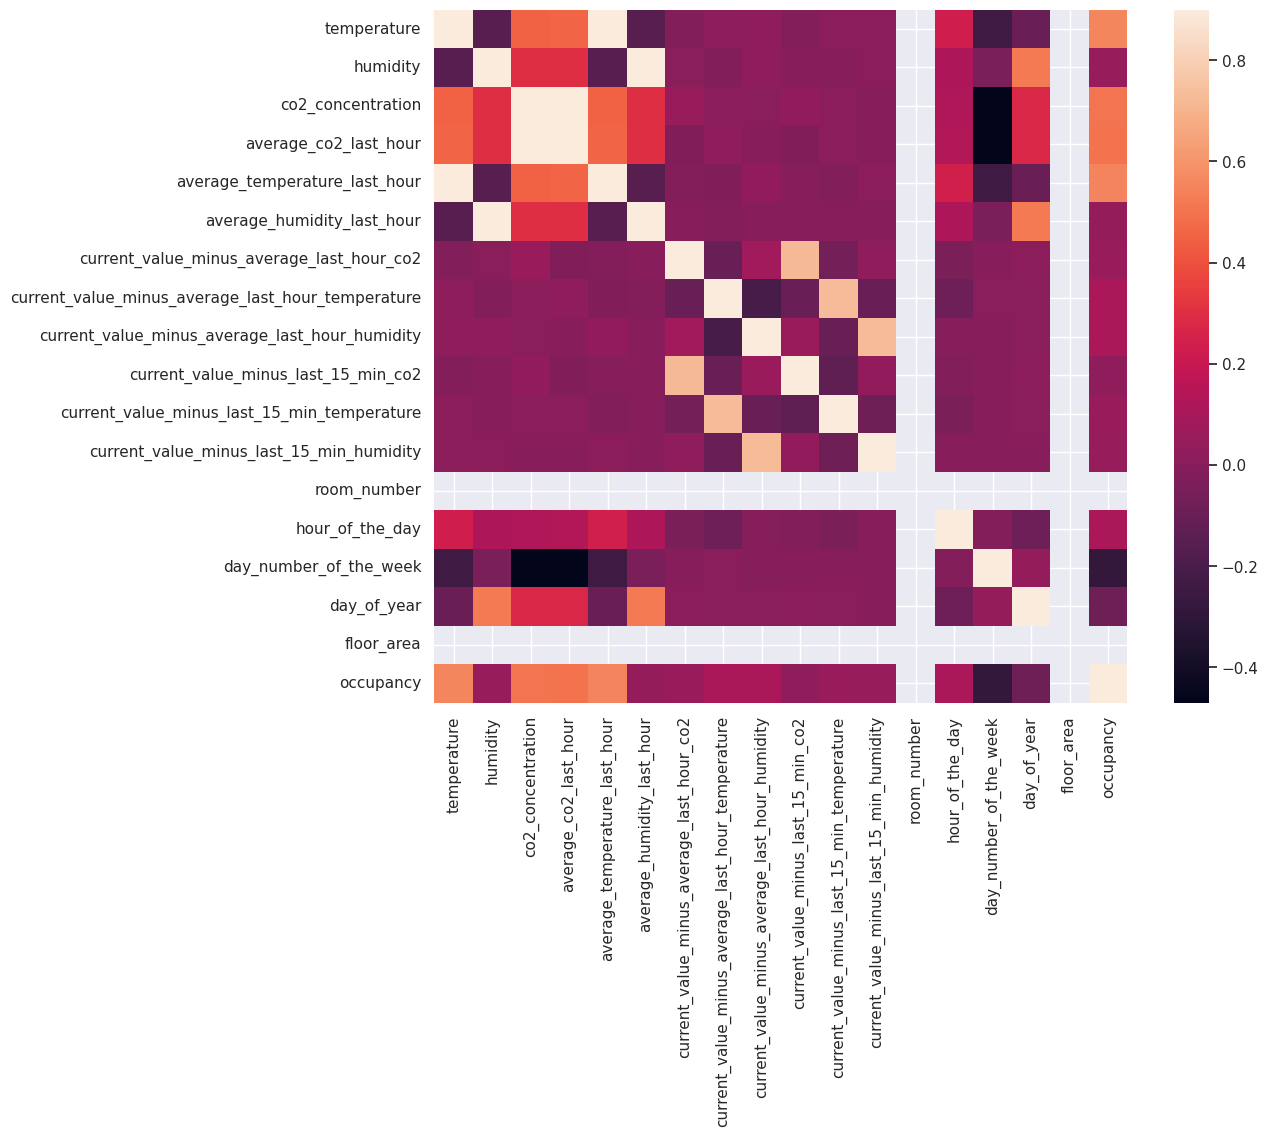

In [ ]:
plt.figure(figsize = (12,9))
sns.heatmap(df_HVAC.drop("datetime", axis=1).corr(), vmax = 0.9, square = True)

### Check if there is specific hours for occupancy

In [ ]:
hours_1 = []
hours_0 = []
for date in df_HVAC[df_HVAC['occupancy'] == 1]['datetime']:
    hours_1.append(date.hour)
for date in df_HVAC[df_HVAC['occupancy'] == 0]['datetime']:
    hours_0.append(date.hour)

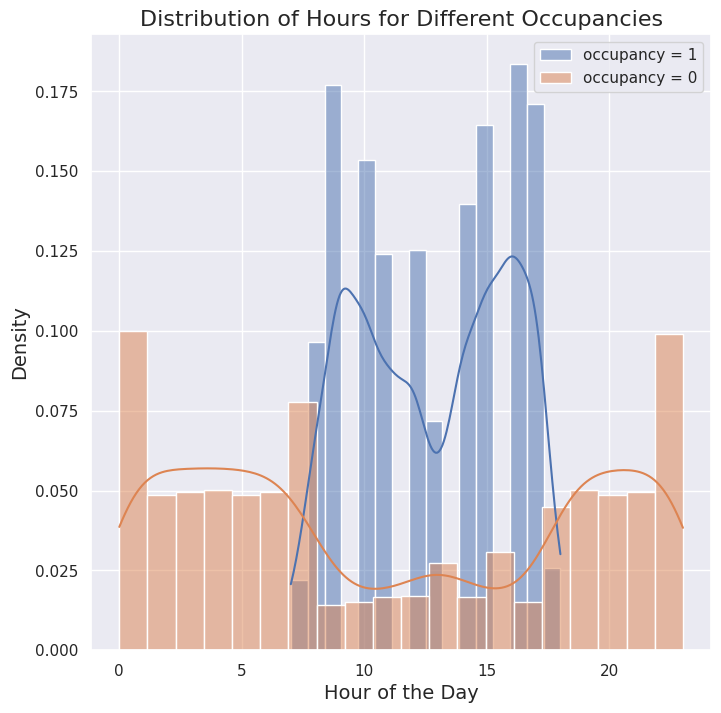

In [ ]:
plt.figure(figsize=(8,8))
ax = sns.histplot(hours_1, kde=True, stat="density", label='occupancy = 1')
ax = sns.histplot(hours_0, kde=True, stat="density", label='occupancy = 0')

plt.legend()

plt.title('Distribution of Hours for Different Occupancies', fontsize=16)
plt.xlabel('Hour of the Day', fontsize=14)
plt.ylabel('Density', fontsize=14)

plt.show()

### Target exploration

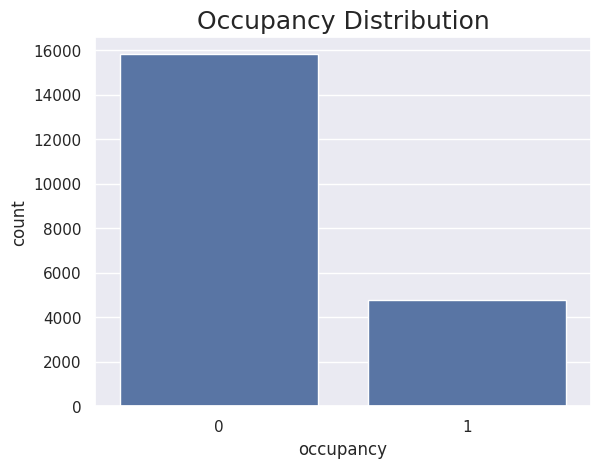

In [ ]:
sns.set(style="darkgrid")
plt.title("Occupancy Distribution", fontdict={'fontsize':18})
ax = sns.countplot(x="occupancy", data=df_HVAC)

### Splitting data

In [ ]:
X = df_HVAC.drop(["datetime", "occupancy"], axis=1)
y = df_HVAC["occupancy"]
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

Training set size: 12336
Validation set size: 4112
Test set size: 4112


### Scaling data

In [ ]:
scaler = MinMaxScaler()
X_train, X_val, X_test = scale_data(scaler, X_train, X_val, X_test)

## ANN

In [ ]:
input_dim = X_train.shape[1]
threshold = 0.45
print(f"input dimension: {input_dim}")
print(f"decision threshold: {threshold}")

input dimension: 17
decision threshold: 0.45


#### Create model

In [ ]:
model = create_model(input_dim, best_kernel_regularizer, best_dropout)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                576       
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1121 (4.38 KB)
Trainable params: 1121 (4.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Train model

In [ ]:
start_time = time.time()
print(f"Training on HVAC with batch size = {best_batch_size} and {best_epochs} epochs")
history_HVAC = model.fit(X_train, y_train, epochs=best_epochs, batch_size=best_batch_size, validation_data=(X_val, y_val), verbose = 0)
training_time_HVAC = time.time() - start_time


Training on HVAC with batch size = 32 and 100 epochs


#### Evaluate Model

In [ ]:
HVAC_results = evaluate(model, history_HVAC, X_train, y_train, X_test, y_test, training_time_HVAC, "HVAC")

129/129 [==============================] - 0s 1ms/step
Results of HVAC dataset
F1 Score on test data: 94.68
Accuracy train data: 97.69%
Accuracy validation data: 97.47%
Accuracy test data: 97.52%
Data length: 12336
Training time: 102 seconds


129/129 [==============================] - 0s 2ms/step


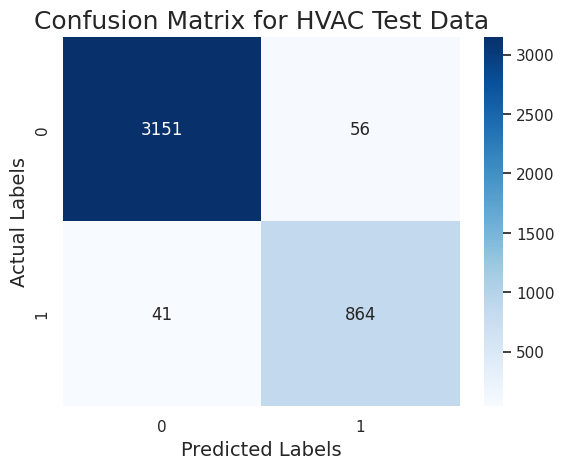

In [ ]:
y_pred = model.predict(X_test)
y_pred = [1 if i >= threshold else 0 for i in y_pred]

plt.title("Confusion Matrix for HVAC Test Data", fontdict={'fontsize':18})
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=["0", "1"], yticklabels=["0", "1"])
ax.set_xlabel('Predicted Labels', fontsize=14)
ax.set_ylabel('Actual Labels', fontsize=14)
plt.show()

# Merge 2 data sets

- An important thing to check is the impact of having different sample rates between both datasets:
HVAC (1 sample per min) VS room_occupancy (1 sample per 15min)

- Another point worth mentionning is the impact of having a balanced target: occupancy = 1 and occupancy = 0

In [ ]:
df_room_occ = pd.read_csv('/content/sample_data/room_occupancy_detection_data.csv')
df_room_occ.head()

,datetime,temperature,humidity,co2_concentration,average_co2_last_hour,average_temperature_last_hour,average_humidity_last_hour,current_value_minus_average_last_hour_co2,current_value_minus_average_last_hour_temperature,current_value_minus_average_last_hour_humidity,current_value_minus_last_15_min_co2,current_value_minus_last_15_min_temperature,current_value_minus_last_15_min_humidity,room_number,hour_of_the_day,day_number_of_the_week,day_of_year,floor_area,occupancy
0,30-01-23 00:00,20.4,37.5,637.1,637.10,20.40,37.50,0.00,0.00,0.00,0.0,0.0,0.0,1,0,1,30,16,0
1,30-01-23 00:15,20.4,37.6,637.6,637.60,20.40,37.60,0.00,0.00,0.00,0.5,0.0,0.1,1,0,1,30,16,0
2,30-01-23 00:30,20.4,37.6,629.0,629.00,20.40,37.60,0.00,0.00,0.00,-8.6,0.0,0.0,1,0,1,30,16,0
3,30-01-23 00:45,20.5,39.1,790.2,790.20,20.50,39.10,0.00,0.00,0.00,161.2,0.1,1.5,1,0,1,30,16,0
4,30-01-23 01:00,20.6,39.7,861.7,673.48,20.43,37.95,188.23,0.18,1.75,71.5,0.1,0.6,1,1,1,30,16,1


In [ ]:
df_room_occ['datetime'] = pd.to_datetime(df_room_occ['datetime'])

<ipython-input-74-b32feff9f802>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_room_occ['datetime'] = pd.to_datetime(df_room_occ['datetime'])


In [ ]:
df = pd.concat([df_HVAC, df_room_occ])
df.reset_index(drop=True, inplace=True)

In [ ]:
#Splitting
X = df[feature_columns]
y = df["occupancy"]
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)
#Scaling
scaler = MinMaxScaler()
X_train, X_val, X_test = scale_data(scaler, X_train, X_val, X_test)

Training set size: 18796
Validation set size: 6266
Test set size: 6266


In [ ]:
#Training
start_time = time.time()
merged_history = model.fit(X_train, y_train, epochs=best_epochs, batch_size=best_batch_size, validation_data=(X_val, y_val), verbose = 0)
training_time_merged = time.time() - start_time

In [ ]:
merged_results = evaluate(model, merged_history, X_train, y_train, X_test, y_test, training_time_merged, "merged")

196/196 [==============================] - 0s 1ms/step
Results of merged dataset
F1 Score on test data: 88.14
Accuracy train data: 95.04%
Accuracy validation data: 94.06%
Accuracy test data: 94.25%
Data length: 18796
Training time: 202 seconds


196/196 [==============================] - 0s 1ms/step


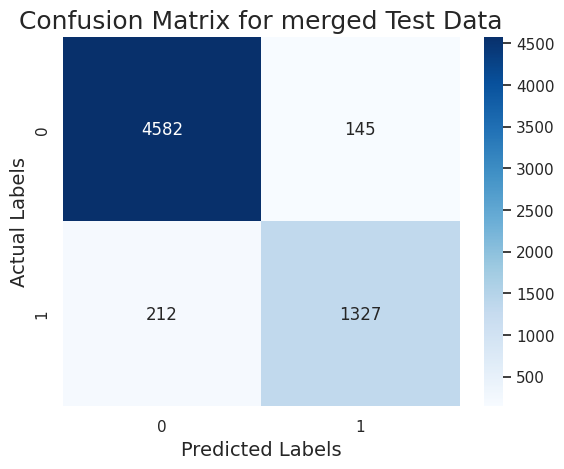

In [ ]:
y_pred = model.predict(X_test)
y_pred = [1 if i >= threshold else 0 for i in y_pred]

plt.title("Confusion Matrix for merged Test Data", fontdict={'fontsize':18})
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=["0", "1"], yticklabels=["0", "1"])
ax.set_xlabel('Predicted Labels', fontsize=14)
ax.set_ylabel('Actual Labels', fontsize=14)
plt.show()

## room_occupancy + HVAC (ssr: 1 sample every 15min)

**Notation** : ssr = same sample rate

In [ ]:
# 1 sample per 15min
df2_ssr = df_HVAC.iloc[11::15]
df2_ssr.reset_index(drop=True, inplace=True)
df2_ssr.describe()

,datetime,temperature,humidity,co2_concentration,average_co2_last_hour,average_temperature_last_hour,average_humidity_last_hour,current_value_minus_average_last_hour_co2,current_value_minus_average_last_hour_temperature,current_value_minus_average_last_hour_humidity,current_value_minus_last_15_min_co2,current_value_minus_last_15_min_temperature,current_value_minus_last_15_min_humidity,room_number,hour_of_the_day,day_number_of_the_week,day_of_year,floor_area,occupancy
count,1370,1370.000000,1370.000000,1370.000000,1370.000000,1370.000000,1370.000000,1370.000000,1370.000000,1370.000000,1370.000000,1370.000000,1370.000000,1370.0,1370.000000,1370.000000,1370.000000,1370.0,1370.000000
mean,2015-02-10 13:54:07.226277376,20.905461,27.655243,691.169818,690.089935,20.905553,27.652952,1.079883,-0.000092,0.002291,0.722871,0.001549,-0.000942,17.0,11.437956,3.897810,41.083942,20.0,0.232847
min,2015-02-02 14:30:00,19.100000,16.865000,418.500000,416.583333,19.050000,16.787083,-105.291667,-1.923750,-1.022083,-123.750000,-0.110000,-1.136667,17.0,0.000000,1.000000,33.000000,20.0,0.000000
25%,2015-02-06 11:23:44.249999872,20.200000,24.495417,461.000000,460.869792,20.191667,24.498438,-3.375000,-0.012500,-0.037500,-2.500000,0.000000,-0.025000,17.0,5.000000,2.000000,37.000000,20.0,0.000000
50%,2015-02-10 00:57:29.500000,20.700000,27.310000,566.000000,565.218750,20.700000,27.290000,-0.218750,0.000000,0.000000,0.000000,0.000000,0.000000,17.0,11.000000,4.000000,41.000000,20.0,0.000000
75%,2015-02-14 19:45:15,21.500000,31.290000,807.750000,804.187500,21.525521,31.260469,3.406250,0.012500,0.033844,2.666667,0.000000,0.025000,17.0,18.000000,6.000000,45.000000,20.0,0.000000
max,2015-02-18 09:19:00,24.356667,39.400000,2065.750000,2014.687500,24.381667,39.345000,501.541667,0.176667,3.946250,323.333333,0.110000,1.160000,17.0,23.000000,7.000000,49.000000,20.0,1.000000
std,NaN,1.053323,4.985505,313.124188,310.225763,1.056147,4.981557,23.675627,0.062056,0.161951,16.791385,0.032452,0.119272,0.0,7.078565,2.059327,4.730220,0.0,0.422800


In [ ]:
df_ssr = pd.concat([df2_ssr, df_room_occ])
df_ssr.reset_index(drop=True, inplace=True)
df_ssr.describe()

,datetime,temperature,humidity,co2_concentration,average_co2_last_hour,average_temperature_last_hour,average_humidity_last_hour,current_value_minus_average_last_hour_co2,current_value_minus_average_last_hour_temperature,current_value_minus_average_last_hour_humidity,current_value_minus_last_15_min_co2,current_value_minus_last_15_min_temperature,current_value_minus_last_15_min_humidity,room_number,hour_of_the_day,day_number_of_the_week,day_of_year,floor_area,occupancy
count,12138,12138.000000,12138.000000,12138.000000,12138.000000,12138.000000,12138.000000,12138.000000,12138.000000,12138.000000,12138.000000,12138.000000,12138.000000,12138.000000,12138.000000,12138.000000,12138.000000,12138.000000,12138.000000
mean,2022-03-28 11:29:27.597627136,20.872565,33.555472,691.143744,691.214987,20.873766,33.549013,-0.069195,0.000342,0.008539,0.011332,0.000270,0.003052,9.459384,11.477838,3.984511,33.917696,18.669303,0.254655
min,2015-02-02 14:30:00,17.600000,16.865000,409.700000,412.350000,17.700000,16.787083,-640.430000,-3.100000,-7.850000,-568.600000,-3.100000,-5.500000,1.000000,0.000000,1.000000,30.000000,9.000000,0.000000
25%,2023-01-30 02:00:00,19.700000,30.233750,568.700000,570.079167,19.700000,30.221563,-14.050000,-0.050000,-0.170000,-10.900000,0.000000,-0.100000,5.000000,5.000000,2.000000,31.000000,16.000000,0.000000
50%,2023-02-02 01:15:00,21.100000,33.300000,664.700000,664.800000,21.100000,33.280000,-0.979583,0.000000,0.000000,-0.666667,0.000000,0.000000,10.000000,11.000000,4.000000,33.000000,20.000000,0.000000
75%,2023-04-02 00:45:00,21.900000,36.600000,772.100000,772.450000,21.930000,36.600000,11.128750,0.030000,0.130000,9.300000,0.000000,0.100000,14.000000,18.000000,6.000000,35.000000,21.000000,1.000000
max,2023-06-02 00:00:00,24.400000,53.400000,2191.200000,2179.900000,24.381667,49.130000,577.500000,0.880000,14.130000,573.900000,0.600000,11.900000,17.000000,23.000000,7.000000,49.000000,33.000000,1.000000
std,NaN,1.280314,5.539438,198.463917,196.550955,1.278526,5.531849,43.435677,0.113204,0.597600,26.534350,0.075494,0.435294,5.107645,6.948003,2.008655,3.552856,6.457718,0.435685


In [ ]:
X_ssr = df_ssr.drop(["datetime", "occupancy"], axis=1)
y_ssr = df_ssr["occupancy"]
ssr_X_train, ssr_X_val, ssr_X_test, ssr_y_train, ssr_y_val, ssr_y_test = split_data(X_ssr, y_ssr)

Training set size: 7282
Validation set size: 2428
Test set size: 2428


In [ ]:
scaler = MinMaxScaler()
ssr_X_train, ssr_X_val, ssr_X_test = scale_data(scaler, ssr_X_train, ssr_X_val, ssr_X_test)

In [ ]:
start_time = time.time()
history_ssr = model.fit(ssr_X_train, ssr_y_train, epochs=best_epochs, batch_size=best_batch_size, validation_data=(ssr_X_val, ssr_y_val), verbose = 0)
training_time_ssr = time.time() - start_time

In [ ]:
ssr_results = evaluate(model, history_ssr, ssr_X_train, ssr_y_train, ssr_X_test, ssr_y_test, training_time_ssr, "same sample rate")

76/76 [==============================] - 0s 1ms/step
Results of same sample rate dataset
F1 Score on test data: 79.86
Accuracy train data: 91.54%
Accuracy validation data: 90.94%
Accuracy test data: 90.32%
Data length: 7282
Training time: 55 seconds


76/76 [==============================] - 0s 1ms/step


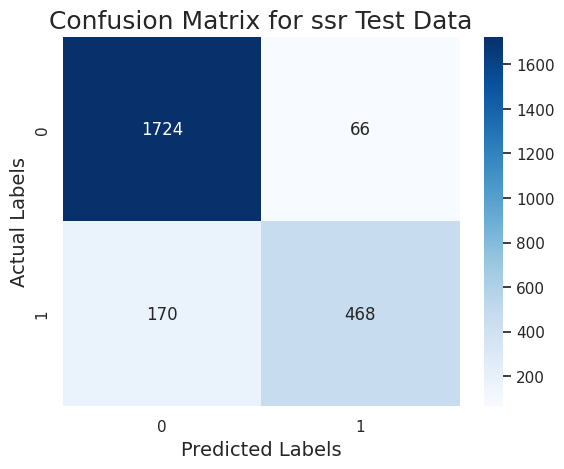

In [ ]:
ssr_y_pred = model.predict(ssr_X_test)
ssr_y_pred = [1 if i >= threshold else 0 for i in ssr_y_pred]

plt.title("Confusion Matrix for ssr Test Data", fontdict={'fontsize':18})
ax = sns.heatmap(confusion_matrix(ssr_y_test, ssr_y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=["0", "1"], yticklabels=["0", "1"])
ax.set_xlabel('Predicted Labels', fontsize=14)
ax.set_ylabel('Actual Labels', fontsize=14)
plt.show()

## room_occupancy + HVAC (dsr: original HVAC) but same number of data

**Notation**: dsr = different sample rate

**NB:** We selected the same number of data for both experiments (ssr and dsr)

In [ ]:
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)
df_dsr = df_shuffled.iloc[: len(df_ssr)]
df_dsr.reset_index(drop=True, inplace=True)
df_dsr.describe()

,datetime,temperature,humidity,co2_concentration,average_co2_last_hour,average_temperature_last_hour,average_humidity_last_hour,current_value_minus_average_last_hour_co2,current_value_minus_average_last_hour_temperature,current_value_minus_average_last_hour_humidity,current_value_minus_last_15_min_co2,current_value_minus_last_15_min_temperature,current_value_minus_last_15_min_humidity,room_number,hour_of_the_day,day_number_of_the_week,day_of_year,floor_area,occupancy
count,12138,12138.000000,12138.000000,12138.000000,12138.000000,12138.000000,12138.000000,12138.000000,12138.000000,12138.000000,12138.000000,12138.000000,12138.000000,12138.000000,12138.000000,12138.000000,12138.000000,12138.000000,12138.000000
mean,2017-11-09 01:28:12.217251584,20.896789,29.908562,693.715875,694.010651,20.896957,29.906616,-0.294002,0.000421,0.002713,-0.368903,0.000254,-0.001776,14.100840,11.450733,3.926182,38.321635,19.441918,0.245098
min,2015-02-02 14:22:00,17.600000,16.823333,409.700000,414.100000,17.700000,16.787083,-911.750000,-3.100000,-4.550000,-1142.750000,-3.100000,-5.500000,1.000000,0.000000,1.000000,30.000000,9.000000,0.000000
25%,2015-02-08 07:43:00,20.100000,25.745000,499.000000,499.802083,20.108333,25.752031,-5.166667,-0.020000,-0.066667,-4.000000,0.000000,-0.050000,12.000000,5.000000,2.000000,34.000000,20.000000,0.000000
50%,2015-02-15 00:27:00,20.800000,30.200000,621.633333,623.475000,20.800000,30.200000,-0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,11.000000,4.000000,37.000000,20.000000,0.000000
75%,2023-01-30 21:30:00,21.700000,33.790000,793.000000,793.100000,21.705625,33.746146,4.750000,0.013750,0.052083,3.750000,0.000000,0.036000,17.000000,18.000000,6.000000,43.000000,20.000000,0.000000
max,2023-06-02 00:00:00,24.408333,53.400000,2184.600000,2165.850000,24.381667,49.130000,742.875000,2.268750,14.130000,450.166667,2.180000,11.900000,17.000000,23.000000,7.000000,49.000000,33.000000,1.000000
std,NaN,1.144620,5.972987,274.353916,273.716638,1.143366,5.961160,31.222180,0.078227,0.397548,22.303659,0.060181,0.316931,4.838553,6.994513,2.039930,5.560385,4.061097,0.430163


In [ ]:
dsr_X = df_dsr.drop(["datetime", "occupancy"], axis=1)
dsr_y = df_dsr["occupancy"]

dsr_X_train, dsr_X_val, dsr_X_test, dsr_y_train, dsr_y_val, dsr_y_test = split_data(dsr_X, dsr_y)

Training set size: 7282
Validation set size: 2428
Test set size: 2428


In [ ]:
scaler = MinMaxScaler()
dsr_X_train, dsr_X_val, dsr_X_test = scale_data(scaler, dsr_X_train, dsr_X_val, dsr_X_test)

In [ ]:
start_time = time.time()
history_dsr = model.fit(dsr_X_train, dsr_y_train, epochs=best_epochs, batch_size=best_batch_size, validation_data=(dsr_X_val, dsr_y_val), verbose = 0)
training_time_dsr = time.time() - start_time

In [ ]:
dsr_results = evaluate(model, history_dsr, dsr_X_train, dsr_y_train, dsr_X_test, dsr_y_test, training_time_dsr, "different sample rate")

76/76 [==============================] - 0s 1ms/step
Results of different sample rate dataset
F1 Score on test data: 87.84
Accuracy train data: 95.96%
Accuracy validation data: 93.9%
Accuracy test data: 93.9%
Data length: 7282
Training time: 54 seconds


76/76 [==============================] - 0s 1ms/step


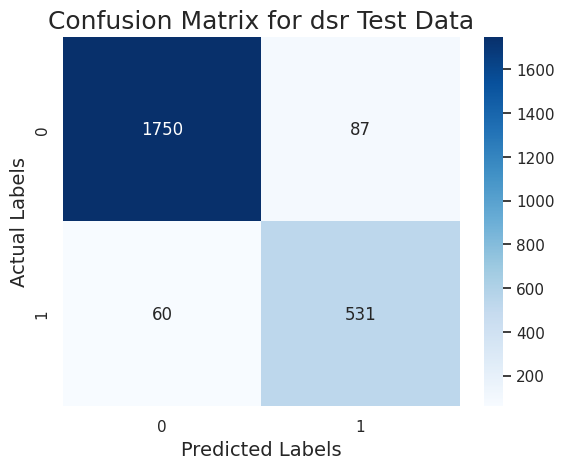

In [ ]:
dsr_y_pred = model.predict(dsr_X_test)
dsr_y_pred = [1 if i >= threshold else 0 for i in dsr_y_pred]

plt.title("Confusion Matrix for dsr Test Data", fontdict={'fontsize':18})
ax = sns.heatmap(confusion_matrix(dsr_y_test, dsr_y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=["0", "1"], yticklabels=["0", "1"])
ax.set_xlabel('Predicted Labels', fontsize=14)
ax.set_ylabel('Actual Labels', fontsize=14)
plt.show()

## Should we keep the same sample rate or not?
For the same number of data (12250 in total):

|         | same sample rate | different sample rate |
|---------|---------|---------|
| test accuracy| 91.93%| 95.3%|


**Having differently sampled data makes our prediction more accurate.**

===> During our data collection we will use different sample rates (1min, 5min, 15min)

## room_occupancy + HVAC (Balance occupancy = 1 and occupancy = 0)

In [ ]:
df2_only_occupancy_1 = df_HVAC[df_HVAC['occupancy'] == 1]
df2_only_occupancy_1.head()

,datetime,temperature,humidity,co2_concentration,average_co2_last_hour,average_temperature_last_hour,average_humidity_last_hour,current_value_minus_average_last_hour_co2,current_value_minus_average_last_hour_temperature,current_value_minus_average_last_hour_humidity,current_value_minus_last_15_min_co2,current_value_minus_last_15_min_temperature,current_value_minus_last_15_min_humidity,room_number,hour_of_the_day,day_number_of_the_week,day_of_year,floor_area,occupancy
0,2015-02-02 14:19:00,23.7000,26.272,749.200000,749.200000,23.700000,26.27200,0.000000,0.000000,0.00000,0.000000,0.0000,0.000,17,14,1,33,20,1
1,2015-02-02 14:19:59,23.7180,26.290,760.400000,760.400000,23.718000,26.29000,0.000000,0.000000,0.00000,11.200000,0.0180,0.018,17,14,1,33,20,1
2,2015-02-02 14:21:00,23.7300,26.230,769.666667,769.666667,23.730000,26.23000,0.000000,0.000000,0.00000,9.266667,0.0120,-0.060,17,14,1,33,20,1
3,2015-02-02 14:22:00,23.7225,26.125,774.750000,774.750000,23.722500,26.12500,0.000000,0.000000,0.00000,5.083333,-0.0075,-0.105,17,14,1,33,20,1
4,2015-02-02 14:23:00,23.7540,26.200,779.000000,763.504167,23.717625,26.22925,15.495833,0.036375,-0.02925,4.250000,0.0315,0.075,17,14,1,33,20,1


In [ ]:
df_balanced = pd.concat([df2_only_occupancy_1, df_room_occ])

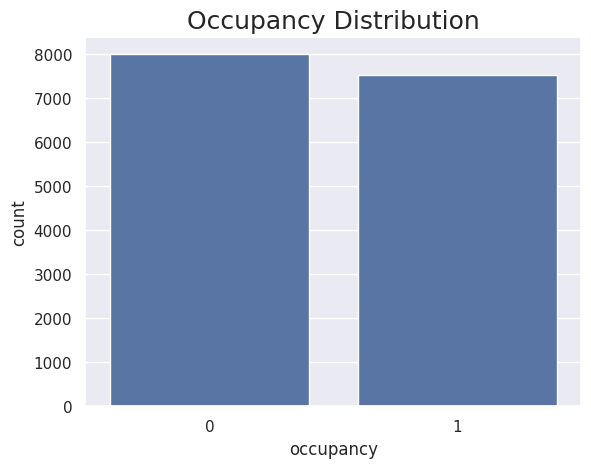

In [ ]:
sns.set(style="darkgrid")
plt.title("Occupancy Distribution", fontdict={'fontsize':18})
ax = sns.countplot(x="occupancy", data=df_balanced)

In [ ]:
#Splitting
balanced_X = df_balanced.drop(["datetime", "occupancy"], axis=1)
balanced_y = df_balanced["occupancy"]
balanced_X_train, balanced_X_val, balanced_X_test, balanced_y_train, balanced_y_val, balanced_y_test = split_data(balanced_X, balanced_y)
#Scaling
scaler = MinMaxScaler()
balanced_X_train, balanced_X_val, balanced_X_test = scale_data(scaler, balanced_X_train, balanced_X_val, balanced_X_test)

Training set size: 9310
Validation set size: 3104
Test set size: 3104


In [ ]:
#Training
start_time = time.time()
history_balanced = model.fit(balanced_X_train, balanced_y_train, epochs=best_epochs, batch_size=best_batch_size, validation_data=(balanced_X_val, balanced_y_val), verbose = 0)
training_time_balanced = time.time() - start_time

In [ ]:
balanced_results = evaluate(model, history_balanced, balanced_X_train, balanced_y_train, balanced_X_test, balanced_y_test, training_time_balanced, "balanced")

97/97 [==============================] - 0s 1ms/step
Results of balanced dataset
F1 Score on test data: 93.16
Accuracy train data: 93.74%
Accuracy validation data: 92.43%
Accuracy test data: 93.11%
Data length: 9310
Training time: 66 seconds


97/97 [==============================] - 0s 1ms/step


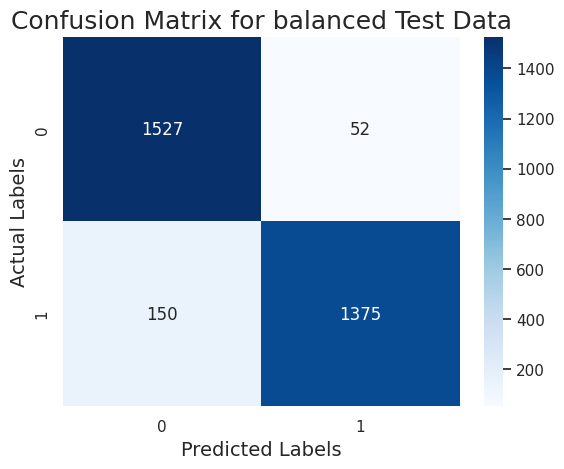

In [ ]:
balanced_y_pred = model.predict(balanced_X_test)
balanced_y_pred = [1 if i >= threshold else 0 for i in balanced_y_pred]

plt.title("Confusion Matrix for balanced Test Data", fontdict={'fontsize':18})
ax = sns.heatmap(confusion_matrix(balanced_y_test, balanced_y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=["0", "1"], yticklabels=["0", "1"])
ax.set_xlabel('Predicted Labels', fontsize=14)
ax.set_ylabel('Actual Labels', fontsize=14)
plt.show()

==> Equal distribution of False negative/positives

# Results

In [ ]:
results = {"HVAC": HVAC_results,
           "merged": merged_results,
           "ssr": ssr_results,
           "dsr": dsr_results,
           "balanced": balanced_results}
indices = ["f1","training accuracy","val accuracy", "test accuracy", "training_data_length", "training time"]

df_results = pd.DataFrame(results, index=indices)
df_results = df_results.round(0).astype(int)

print(df_results)

                       HVAC  merged   ssr   dsr  balanced
f1                       95      88    80    88        93
training accuracy        98      95    92    96        94
val accuracy             97      94    91    94        92
test accuracy            98      94    90    94        93
training_data_length  12336   18796  7282  7282      9310
training time           102     202    55    54        66


# Conclusion

**Lessons Learned:**

*   We need data that has a balanced target distribution close to 50-50
*   Having the same sample rate does not increase accuracy
*   Time features increase preformance on the surface but are biased and can not generalize the model

